# Load Model, Evaluate, & Output Results

In [1]:
#Install some required packages

!pip install --quiet "pytorch-lightning" "torchmetrics" "torchvision" "torch"
!pip install --quiet ipywidgets widgetsnbextension pandas-profiling
!jupyter nbextension enable --py widgetsnbextension

import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from ipywidgets import FloatProgress
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

####################################################################################
####################################################################################
# Make sure to select correct version of dataset for evaluation
#version = 'cdetect'
#version = 'cdetect_v2'
#version = 'cdetect_compose_v2'
#version = 'cdetect_all_v2'
version = 'cdetect_v2_with_gan'
####################################################################################
####################################################################################

# Store tensorboard logs
writer = SummaryWriter(log_dir="/workspace/data/"+version)


SEED=1
random.seed(SEED)
torch.manual_seed(SEED)
cudnn.deterministic = True
torch.cuda.device_count()

ARCH = 'vgg16'
START_EPOCH = 0
EPOCHS = 100
LR = 0.0001 #LOWERED LR BY A FACTOR OF 10 FOR PRETRAINED MODEL
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
PRINT_FREQ = 1
TRAIN_BATCH=16
VAL_BATCH=16
TEST_BATCH=16
WORKERS=2
TRAINDIR="/workspace/"+version+"/train"
VALDIR="/workspace/"+version+"/val"
TESTDIR="/workspace/"+version+"/test"

if not torch.cuda.is_available():
    print('GPU not detected.. did you pass through your GPU?')

GPU = 0
torch.cuda.set_device(GPU)
cudnn.benchmark = True

def train(train_loader, model, criterion, optimizer):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    #top3 = AverageMeter('Acc@3', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1],
        #[batch_time, data_time, losses, top1],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        if GPU is not None:
            images = images.cuda(GPU, non_blocking=True)
        if torch.cuda.is_available():
            target = target.cuda(GPU, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc3 = accuracy(output, target, topk=(1, 3))
        #acc1 = accuracy(output, target, topk=(1, 1))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        #top3.update(acc3[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINT_FREQ == 0:
            progress.display(i)
            
            
def validate(val_loader, model, criterion, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if GPU is not None:
                images = images.cuda(GPU, non_blocking=True)
            if torch.cuda.is_available():
                target = target.cuda(GPU, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc3 = accuracy(output, target, topk=(1, 3))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINT_FREQ == 0:
                progress.display(i)

        print(' * Acc@1 {top1.avg:.3f}'
              .format(top1=top1))

    return top1.avg

def save_checkpoint(state, is_best, filename='/workspace/'+version+'/checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, '/workspace/'+version+'/model_best.pth.tar')
        
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
    
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
    
#Need to be able to access file path for our train/val/test dataloader so we can output CNN model predictions with file path
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. 
    Extends torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
imagenet_mean_RGB = [0.47889522, 0.47227842, 0.43047404]
imagenet_std_RGB = [0.229, 0.224, 0.225]
# cinic_mean_RGB = [0.47889522, 0.47227842, 0.43047404]
# cinic_std_RGB = [0.24205776, 0.23828046, 0.25874835]
# cifar_mean_RGB = [0.4914, 0.4822, 0.4465]
# cifar_std_RGB = [0.2023, 0.1994, 0.2010]

IMG_SIZE = 512
NUM_CLASSES = 3

#Initialize VGG16 base model
model = models.__dict__[ARCH](pretrained=True)
optimizer = torch.optim.SGD(model.parameters(), LR,
                                momentum=MOMENTUM,
                                weight_decay=WEIGHT_DECAY)

#Change the model's output layer to 3 classes (covid/normal/bacterial)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, NUM_CLASSES)
model.cuda(GPU)

#Load saved model weights and state_dict
#checkpoint = torch.load('/workspace/'+version+'/checkpoint.pth.tar')
checkpoint = torch.load('/workspace/'+version+'/model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

#Switch to evaluation mode
model.eval()

criterion = nn.CrossEntropyLoss().cuda(GPU)

optimizer = torch.optim.SGD(model.parameters(), LR,
                                momentum=MOMENTUM,
                                weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean_RGB, imagenet_std_RGB),
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean_RGB, imagenet_std_RGB),
])


train_dataset = ImageFolderWithPaths(root=TRAINDIR, transform=transform_train)

val_dataset = ImageFolderWithPaths(root=VALDIR, transform=transform_val)

# Can use transform_val for the test dataset as well
test_dataset = ImageFolderWithPaths(root=TESTDIR, transform=transform_val)

train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=TRAIN_BATCH, shuffle=True,
        num_workers=WORKERS, pin_memory=True, sampler=None)

val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=VAL_BATCH, shuffle=False,
        num_workers=WORKERS, pin_memory=True, sampler=None) 

test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=TEST_BATCH, shuffle=False,
        num_workers=WORKERS, pin_memory=True, sampler=None) 


# Create image helper functions

#Reverse the tensor transformations to get original image (so that we can learn from model misclassifications later)
def color_correct_tensor_transforms(img):
    return (np.array(img.to('cpu').permute(1, 2, 0))*imagenet_std_RGB + imagenet_mean_RGB)

#Created this function to get around error messages due to (very) small pixel values above 1 or below 0
def img_min_max(img):
    img = img.flatten()
    for i, pixel in enumerate(img):
        if pixel < 0:
            img[i] = 0
        if pixel > 1:
            img[i] = 1
    return img.reshape(IMG_SIZE, IMG_SIZE, 3)


# Create lists to hold all of our model images, paths, and predictions

out_images_master = []
final_targets_master = []
out_preds_master = []
final_preds_master = []
output_paths_master = []

# Reduce batch sizes to prevent memory issues

TRAIN_BATCH=8
VAL_BATCH=8
TEST_BATCH=8

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Evaluating Train Performance

Train Acc@1 82.500


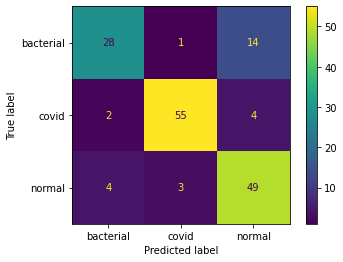

In [2]:
key = {0: 'bacterial', 1: 'covid', 2: 'normal'}

# Create lists to hold all of our model images, paths, and predictions for this evaluation 
out_images = []
final_targets = []
out_preds = []
final_preds = []
output_paths = []

top1 = AverageMeter('Acc@1', ':6.2f')

for i, (images, target, paths) in enumerate(train_loader):

    if GPU is not None:
        images = images.cuda(GPU, non_blocking=True)
    if torch.cuda.is_available():
        target = target.cuda(GPU, non_blocking=True)

    # compute output
    output = model(images)
    loss = criterion(output, target)
    acc1, acc3 = accuracy(output, target, topk=(1, 3))
    top1.update(acc1[0], images.size(0))
    
    #Store images in list
    for image in images:
        out_images.append(color_correct_tensor_transforms(image))
    
    for _ in target:
        final_targets.append(key[int(_.to('cpu'))])
        
    for path in paths:
        output_paths.append(path)
        
    out_preds.extend(output.cpu().detach().numpy())

for pred in out_preds:
    max_value = max(pred)
    final_preds.extend([key[index] for index, item in enumerate(pred) if item == max_value])    
    
print('Train Acc@1 {top1.avg:.3f}'.format(top1=top1))

#Display confusion matrix
labels = [key[x] for x in key]
cm = confusion_matrix(final_targets, final_preds)
ConfusionMatrixDisplay(cm,display_labels=labels).plot()
plt.show()


#Display incorrectly predicted images
mismatch_images = []
mismatch_targets = []
mismatch_preds = []

for i, pred in enumerate(final_preds):
    if final_preds[i] != final_targets[i]:
        mismatch_images.append(img_min_max(out_images[i]))
        mismatch_targets.append(final_targets[i])
        mismatch_preds.append(final_preds[i])

cols = 3
rows = int(np.ceil(len(mismatch_preds)/cols))

# try:
#     fig, axs = plt.subplots(rows,cols, figsize=(15, 15))
#     fig.subplots_adjust(hspace = .005, wspace= .1)
#     axs = axs.ravel()

#     #Remove blank plots in our image grid
#     if len(mismatch_preds) < rows*cols:
#         for i in range(rows*cols):
#             try:
#                 mismatch_preds[i]
#             except:
#                 axs[i].set_axis_off()

#     #Display images where predicted != actual label
#     for i, pred in enumerate(mismatch_preds):
#         #axs[5].set_axis_off()
#         axs[i].axis('off')
#         axs[i].imshow(mismatch_images[i])
#         axs[i].set_title('True Label: {}\n Predicted Label: {}\n'.format(mismatch_targets[i], mismatch_preds[i]),fontsize=15)
# except:
#     print('No incorrect predictions to display!')    

out_images_master.extend(out_images)
final_targets_master.extend(final_targets)
out_preds_master.extend(out_preds)
final_preds_master.extend(final_preds)
output_paths_master.extend(output_paths)

# Evaluate Validation Performance

Val Acc@1 100.000


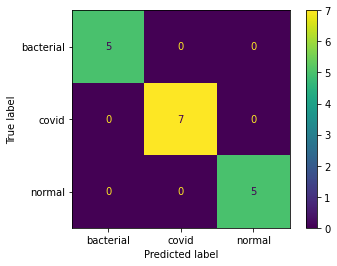

No incorrect predictions to display!


<Figure size 1080x1080 with 0 Axes>

In [3]:
key = {0: 'bacterial', 1: 'covid', 2: 'normal'}

top1 = AverageMeter('Acc@1', ':6.2f')

# Create lists to hold all of our model images, paths, and predictions for this evaluation 
out_images = []
final_targets = []
out_preds = []
final_preds = []
output_paths = []


for i, (images, target, paths) in enumerate(val_loader):

    if GPU is not None:
        images = images.cuda(GPU, non_blocking=True)
    if torch.cuda.is_available():
        target = target.cuda(GPU, non_blocking=True)

    # compute output
    output = model(images)
    loss = criterion(output, target)
    acc1, acc3 = accuracy(output, target, topk=(1, 3))
    top1.update(acc1[0], images.size(0))
    
    #Store images in list
    for image in images:
        out_images.append(color_correct_tensor_transforms(image))
    
    for _ in target:
        final_targets.append(key[int(_.to('cpu'))])
        
    for path in paths:
        output_paths.append(path)
        
    out_preds.extend(output.cpu().detach().numpy())

for pred in out_preds:
    max_value = max(pred)
    final_preds.extend([key[index] for index, item in enumerate(pred) if item == max_value])    
    
print('Val Acc@1 {top1.avg:.3f}'.format(top1=top1))

#Display confusion matrix
labels = [key[x] for x in key]
cm = confusion_matrix(final_targets, final_preds)
ConfusionMatrixDisplay(cm,display_labels=labels).plot()
plt.show()

#Display incorrectly predicted images
mismatch_images = []
mismatch_targets = []
mismatch_preds = []

for i, pred in enumerate(final_preds):
    if final_preds[i] != final_targets[i]:
        mismatch_images.append(img_min_max(out_images[i]))
        mismatch_targets.append(final_targets[i])
        mismatch_preds.append(final_preds[i])

cols = 3
rows = int(np.ceil(len(mismatch_preds)/cols))

try:
    fig, axs = plt.subplots(rows,cols, figsize=(15, 15))
    fig.subplots_adjust(hspace = .005, wspace= .1)
    axs = axs.ravel()

    #Remove blank plots in our image grid
    if len(mismatch_preds) < rows*cols:
        for i in range(rows*cols):
            try:
                mismatch_preds[i]
            except:
                axs[i].set_axis_off()

    #Display images where predicted != actual label
    for i, pred in enumerate(mismatch_preds):
        #axs[5].set_axis_off()
        axs[i].axis('off')
        axs[i].imshow(mismatch_images[i])
        axs[i].set_title('True Label: {}\n Predicted Label: {}\n'.format(mismatch_targets[i], mismatch_preds[i]),fontsize=15)
except:
    print('No incorrect predictions to display!')
    
out_images_master.extend(out_images)
final_targets_master.extend(final_targets)
out_preds_master.extend(out_preds)
final_preds_master.extend(final_preds)
output_paths_master.extend(output_paths)

# Evaluate Test Performance

Test Acc@1 75.000


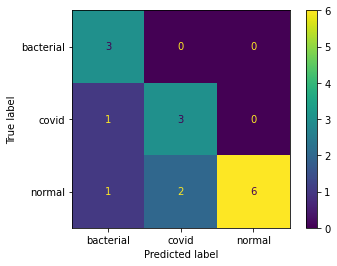

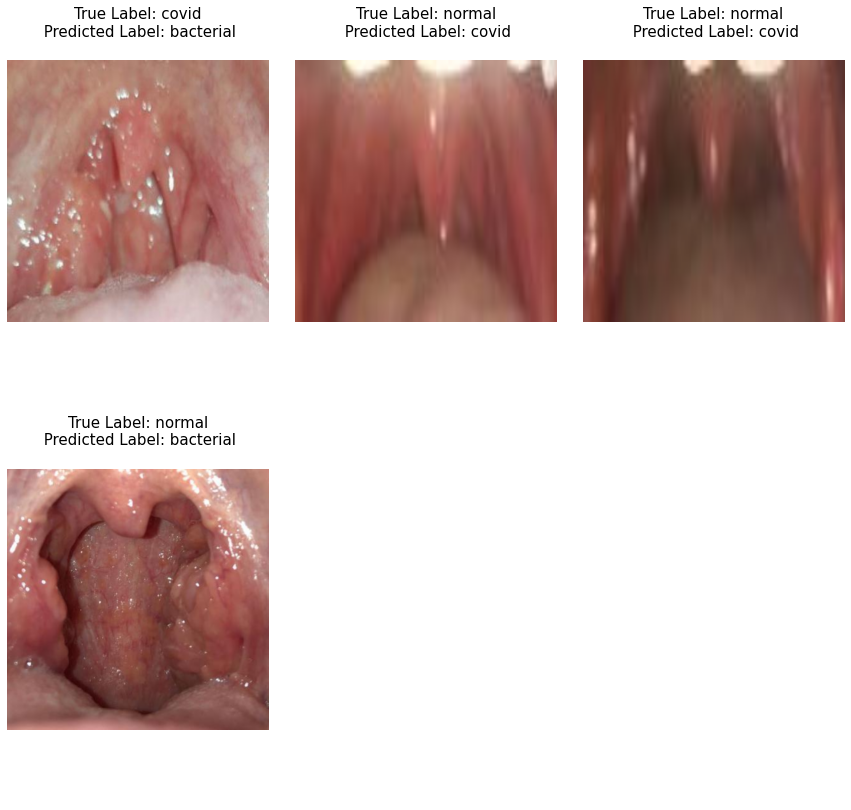

In [4]:
key = {0: 'bacterial', 1: 'covid', 2: 'normal'}

top1 = AverageMeter('Acc@1', ':6.2f')

# Create lists to hold all of our model images, paths, and predictions for this evaluation 
out_images = []
final_targets = []
out_preds = []
final_preds = []
output_paths = []


for i, (images, target, paths) in enumerate(test_loader):

    if GPU is not None:
        images = images.cuda(GPU, non_blocking=True)
    if torch.cuda.is_available():
        target = target.cuda(GPU, non_blocking=True)

    # compute output
    output = model(images)
    loss = criterion(output, target)
    acc1, acc3 = accuracy(output, target, topk=(1, 3))
    top1.update(acc1[0], images.size(0))
    
    #Store images in list
    for image in images:
        out_images.append(color_correct_tensor_transforms(image))
    
    for _ in target:
        final_targets.append(key[int(_.to('cpu'))])
        
    for path in paths:
        output_paths.append(path)
        
    out_preds.extend(output.cpu().detach().numpy())

for pred in out_preds:
    max_value = max(pred)
    final_preds.extend([key[index] for index, item in enumerate(pred) if item == max_value])    
    
print('Test Acc@1 {top1.avg:.3f}'.format(top1=top1))

#Display confusion matrix
labels = [key[x] for x in key]
cm = confusion_matrix(final_targets, final_preds)
ConfusionMatrixDisplay(cm,display_labels=labels).plot()
plt.show()

#Display incorrectly predicted images
mismatch_images = []
mismatch_targets = []
mismatch_preds = []

for i, pred in enumerate(final_preds):
    if final_preds[i] != final_targets[i]:
        mismatch_images.append(img_min_max(out_images[i]))
        mismatch_targets.append(final_targets[i])
        mismatch_preds.append(final_preds[i])

cols = 3
rows = int(np.ceil(len(mismatch_preds)/cols))

try:
    fig, axs = plt.subplots(rows,cols, figsize=(15, 15))
    fig.subplots_adjust(hspace = .005, wspace= .1)
    axs = axs.ravel()

    #Remove blank plots in our image grid
    if len(mismatch_preds) < rows*cols:
        for i in range(rows*cols):
            try:
                mismatch_preds[i]
            except:
                axs[i].set_axis_off()

    #Display images where predicted != actual label
    for i, pred in enumerate(mismatch_preds):
        #axs[5].set_axis_off()
        axs[i].axis('off')
        axs[i].imshow(mismatch_images[i])
        axs[i].set_title('True Label: {}\n Predicted Label: {}\n'.format(mismatch_targets[i], mismatch_preds[i]),fontsize=15)
except:
    print('No incorrect predictions to display!')
    
out_images_master.extend(out_images)
final_targets_master.extend(final_targets)
out_preds_master.extend(out_preds)
final_preds_master.extend(final_preds)
output_paths_master.extend(output_paths)

In [5]:
# Create columns for patient_id and group (train/val/test)
patient_ids = []
group = []
for path in output_paths_master:
    # Find start and end of patient_id
    term = 'R_'
    start = path.find(term)
    end = start + path[start+len(term):].find('_') + len(term)
    patient_ids.append((path[start:end]))
    
    # Find start and end of train/val/test group
    term = '/workspace/'+version+'/'
    start = path.find(term)
    end = start + path[start+len(term):].find('/') + len(term)
    group.append((path[len(term):end]))

# Create output summary dataframe (image-level)
df = pd.DataFrame()
df['path'] = output_paths_master
df['group'] = group
df['patient_id'] = patient_ids
df['bacterial_score'] = [out_preds_master[i][0] for i in range(len(out_preds_master))]
df['covid_score'] = [out_preds_master[i][1] for i in range(len(out_preds_master))]
df['normal_score'] = [out_preds_master[i][2] for i in range(len(out_preds_master))]
#df['final_pred'] = final_preds_master
df['target'] = final_targets_master

# Drop out blank patient_ids (GAN images)
df = df[df['patient_id']!='']

# Aggregate the scores down to the patient level (using averages if the patient had multiple images)
patient_scores = df.groupby(['patient_id']).mean()
patient_preds = pd.DataFrame(df.groupby(['patient_id']).mean().idxmax(axis=1).apply(lambda x: x[:x.find('_score')]), columns=['prediction'])
patient_targets = df.groupby(['patient_id']).max()[['target', 'group']]
final_df = patient_scores.join(patient_preds, how='left', on='patient_id').join(patient_targets, how='left', on='patient_id')

# Save to CSV
#final_df.to_csv('model_outputs_patient_level_original_images.csv')
#final_df.to_csv('model_outputs_patient_level_original_images_plus_all_compose.csv')
final_df.to_csv('model_outputs_patient_level_original_images_plus_gan.csv')
final_df.head()

,bacterial_score,covid_score,normal_score,prediction,target,group
patient_id,,,,,,
R_0dE4arEYyn9VJOV,0.300199,-0.892526,1.172377,normal,covid,train
R_10vi04lh64FGSvp,-1.288195,0.253705,1.371606,normal,normal,val
R_114rz6JiHw1akAz,-2.092546,2.680007,-1.237895,covid,covid,train
R_12JQheYe68Gad2a,1.141612,-1.313291,0.799873,bacterial,normal,train
R_1CwPCqYEGxeiu3r,-1.815154,2.594276,-1.041886,covid,covid,train


In [6]:
print("Patient Level Accuracy: {}".format(1-sum(final_df[final_df['target']!=final_df['prediction']]['group']!='train')/len(final_df[final_df['group']!='train'])))

Patient Level Accuracy: 0.875
